# Getting Started

## Preamble

This challenge has been constructed using the python library `ansyscodefest`, which is already installed in this environment.

This text block you are currently reading is contained within what is known as a cell in a ["**jupyter notebook**"](https://jupyter.org/). If you've never used a jupyter notebook before then I recommend checking out the jupyter documentation as well as this quickstart article on Ansys' developer portal: ["JupyterLab Quick Start"](https://developer.ansys.com/blog/jupyterlab-quick-start), although you can skip the installation steps.

This notebook is open in AnsysLab, which is based on JupyterLab. JupyterLab/AnsysLab are simply alternative ways of viewing and editing jupyter notebooks.

Fundamentally, however, jupyter notebooks provide a way to write mid-length Python scripts within an interactive Python environment whilst also including markdown blocks for well-formatted documentation. Each "cell" in a notebook can be a Python cell or a markdown cell, and you can toggle between them.

This AnsysLab environment also has access to Ansys tools, including MAPDL and PyMAPDL. It is recommended that you perform development in AnsysLab so that everyone has the same working environment.

## The Challenge

In order to begin the challenge we must import the `ansyscodefest` library in a Python cell, like below, and create a game instance by calling the `play()` function. Once it is complete, you can run the `display_challenge()` function to see what you're dealing with. In this example I will take you through the tutorial challenge. When you are ready to begin, run the cell below.


In [1]:
import ansyscodefest as acf


game = acf.play(tutorial=True)
game.display_challenge()

## Chamber 11

You are a dwarven builder in the fourth age of middle earth. Sauron has been defeated and now the great clean-up effort begins. You are a dwarf of note and "Renowned in middle-earth for your building prowess"... at least that's what it said on the ad. And now you've been hired to have a go at fixing the mess that is the mines of Moria. But to start with you need to get your teams *in* and there's a conspicuous lack of bridges leading to the interior of the structure.

In order to get your teams across you need to make a bridge across the gap. It needn't be perfect but it does need to be able to support a constant flow of material and people. Your calculations suggest that each node will be loaded with at most *1 metric ton* at any one time.

Whilst surveying the area, you notice there's still quite a few *rocks* around that you can make use of. They can be bolted onto and reinforce your bridge structures.

The famous wizard Gandalf has also agreed to help you out, an une

OK. Once you've finished reading that spiel (you can copy/paste it into a markdown cell for improved readability if you'd like) you should have an idea of the challenge that lies ahead. So how do we go about solving it?

## Breaking Down The Problem

> This example won't solve each stage for you, but it will give you the tools you need to get going.

This challenge has 3 clear problems.

1. Data parsing - getting the rock node details into Python objects
2. Bridge geometry - deciding on structure geometry as well as cross-section geometry
3. Checking - 5 tries is not enough to see what works and what does not. You need to write a PyMAPDL simulation that can check your design.

### Part 1: Data Parsing

Starting with number 1, we can use our `game` object to generate an input file.

In [4]:
game.generate_challenge_input()

Then we can use Python to parse that.

### Part 2: Bridge geometry!

The crux of the challenge. In the Python cell below I have written a script that builds the most simple bridge possible in this situation.

Remember you need to have a list of nodes, which should also be numbered (and NOT conflict with the existing rock nodes as well as the start and end nodes (1 & 2)), as well as a list of beams.

Node 1 is at (-5, 2) and Node 2 is at (+5, 3).


In [3]:
nodes = [[i+3, -4+i, 2] for i in range(9)]
beams = [[1, 3], [11, 2]] + [[i, j] for i, j in zip(range(3, 11), range(4, 12))]
load_path = [1] + [i for i in range(3, 12)] + [2]
attempt = {'nodes': nodes, 'beams': beams, 'load_path':load_path, 'cross-section': acf.BeamXn.RECTANGLE, 'dimensions': [0.09, 0.09]}
attempt

{'nodes': [[3, -4, 2],
  [4, -3, 2],
  [5, -2, 2],
  [6, -1, 2],
  [7, 0, 2],
  [8, 1, 2],
  [9, 2, 2],
  [10, 3, 2],
  [11, 4, 2]],
 'beams': [[1, 3],
  [11, 2],
  [3, 4],
  [4, 5],
  [5, 6],
  [6, 7],
  [7, 8],
  [8, 9],
  [9, 10],
  [10, 11]],
 'load_path': [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2],
 'cross-section': <BeamXn.RECTANGLE: 1>,
 'dimensions': [0.09, 0.09]}

Now, normally submitting this bridge straight to the program would be too risky and we'd move onto Part 3, however, in the tutorial we get infinite lives so it is worth trying out here and now to see what happens.


In [ ]:
game.submit_attempt(attempt)


Oof! 2 out of our 10 beams broke and experienced stress well beyond the yield strength. We should modify our attempt to include some braces against those rocks. We can use rock 123 at (5, 1) and 122 at (-5, 1) to bolster our bridge with 2 additional beams.

> We don't need to include the rocks as nodes in our attempt because they already exist! We just need to refer to their number.


In [4]:
attempt['beams'].extend([[122, 3], [123, 11]])
attempt


{'nodes': [[3, -4, 2],
  [4, -3, 2],
  [5, -2, 2],
  [6, -1, 2],
  [7, 0, 2],
  [8, 1, 2],
  [9, 2, 2],
  [10, 3, 2],
  [11, 4, 2]],
 'beams': [[1, 3],
  [11, 2],
  [3, 4],
  [4, 5],
  [5, 6],
  [6, 7],
  [7, 8],
  [8, 9],
  [9, 10],
  [10, 11],
  [122, 3],
  [123, 11]],
 'load_path': [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2],
 'cross-section': <BeamXn.RECTANGLE: 1>,
 'dimensions': [0.09, 0.09]}

In [ ]:
game.submit_attempt(attempt)


Much better! The bridge now survives, although it's quite hefty. We used 842 kg of steel. It's lucky we can ignore the bridge's mass when it comes to the load on each node. I am sure that you could do better. But in the real challenge you won't be able to iterate like this, at least not *much*. You'll need to write your own PyMAPDL simulation to simulate your bridge ahead of submission. This brings us to...

### Part 3: Checking

In order to iterate on our design we need to write our own simulation of the bridge. A basic script using PyMAPDL is shown below that simulates the bridge in the challenge.


C:\Users\jderrick\GitHub\VATech_codefest\venv\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


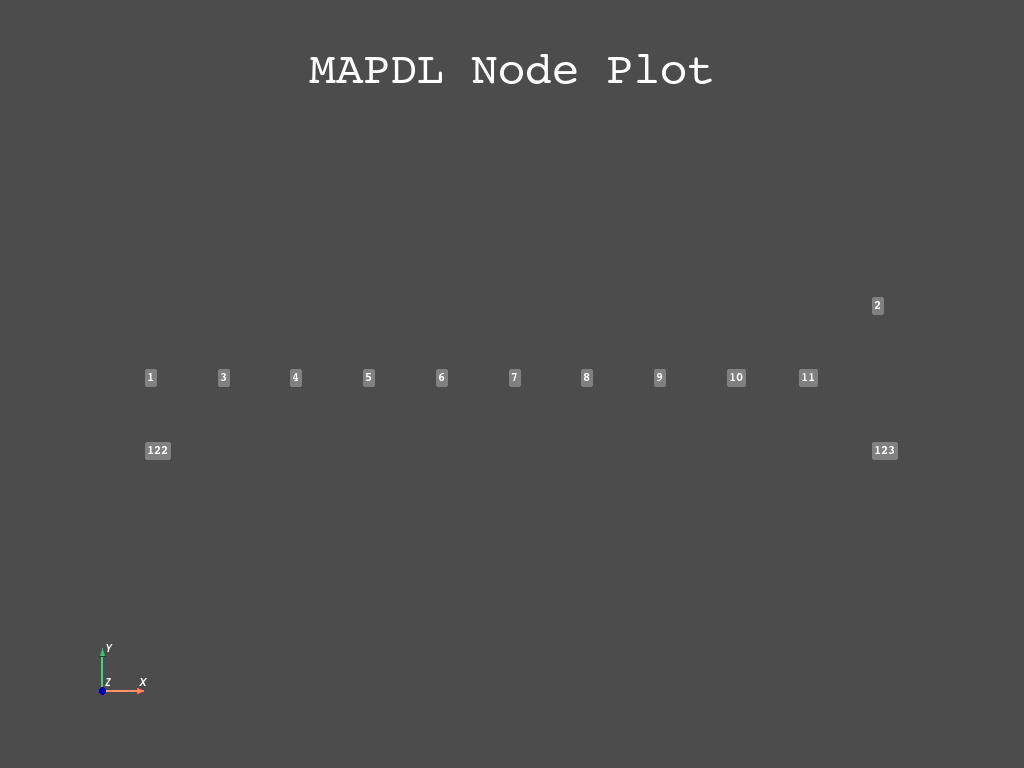

C:\Users\jderrick\GitHub\VATech_codefest\venv\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


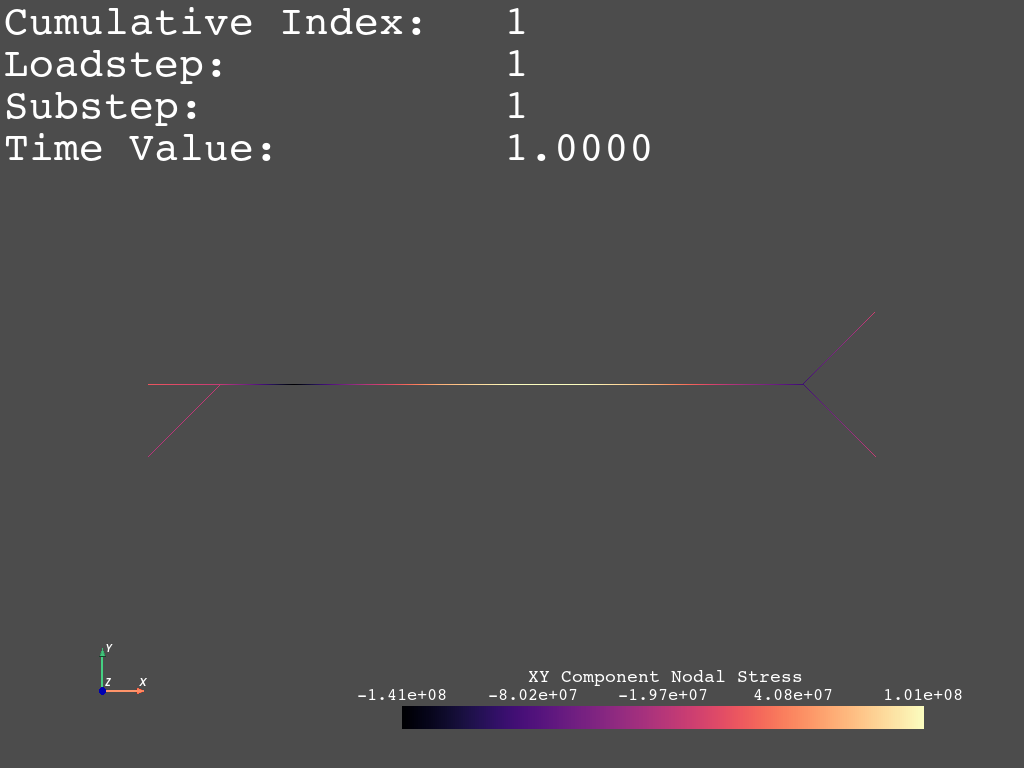

In [11]:
from ansys.mapdl.core import launch_mapdl


# start mapdl and clear it
mapdl = launch_mapdl()
mapdl.clear()  # optional as MAPDL just started
mapdl.units("SI")  # SI - International system (m, kg, s, K).
mapdl.prep7()

mapdl.antype("STATIC")
mapdl.et(1, "BEAM188")
mapdl.sectype(1, "BEAM", "RECT")
mapdl.secdata(attempt['dimensions'][0], attempt['dimensions'][1])


mapdl.mp("EX", 1, acf.STEEL.elastic_modulus)
mapdl.mp("PRXY", acf.STEEL.poissons_ratio)

for node in attempt['nodes']:
    mapdl.n(node[0], node[1], node[2], 0)

# Note: We have to include 1, 2 and the rock nodes we want to use
fixed_nodes = [[1, -5, 2], [2, 5, 3], [122, -5, 1], [123, 5, 1]]
for node in fixed_nodes:
    mapdl.n(node[0], node[1], node[2], 0)

for beam in attempt['beams']:
    mapdl.e(beam[0], beam[1])


mapdl.nplot(True,cpos='xy')
# constrain fixed nodes by removing their degrees of freedom
mapdl.nsel("ALL")
for n in fixed_nodes:
    mapdl.d(n[0], "ALL")

# Apply the 1 ton of force to each node
for node in attempt['load_path']:
    mapdl.f(node, "FY", -9.81*1000.)

mapdl.finish()
mapdl.run("/SOLU")
mapdl.solve()
mapdl.finish()
mapdl.post1()
simulation_result = mapdl.result
simulation_result.plot_nodal_stress(0, 'XY', cpos='xy', cmap='magma')

mapdl.finish()
# This command is arguably the most important!
# Make sure it gets called when you're done otherwise your
# MAPDL instances will hang forever!
mapdl.exit()


Run the cell below to see the full range of materials available to you.

In [3]:
for material in acf.MATERIALS.values():
    print(material)


Material(name='Steel', density=7850.0, elastic_modulus=210000000000.0, poissons_ratio=0.29, yield_strength=330000000.0, price_per_kg=1.2, id=1)
Material(name='Copper', density=8940.0, elastic_modulus=125000000000.0, poissons_ratio=0.345, yield_strength=30000000.0, price_per_kg=9.3, id=2)
Material(name='Aluminum', density=2800.0, elastic_modulus=70000000000.0, poissons_ratio=0.33, yield_strength=270000000.0, price_per_kg=3.5, id=3)
Material(name='Expanded Polystyrene', density=24.0, elastic_modulus=7000000.0, poissons_ratio=0.275, yield_strength=175000.0, price_per_kg=3.0, id=4)
Material(name='Titanium', density=4500.0, elastic_modulus=110000000000.0, poissons_ratio=0.35, yield_strength=500000000.0, price_per_kg=15.0, id=5)
Material(name='Cast Iron', density=7000.0, elastic_modulus=90000000000.0, poissons_ratio=0.26, yield_strength=80000000.0, price_per_kg=0.5, id=6)
Material(name='Diamond', density=3500.0, elastic_modulus=1100000000000.0, poissons_ratio=0.2, yield_strength=2850000000.0

And with that you have all the tools you need to tackle this challenge. Feel free to play around with the tutorial as much as you want and when you're ready, open the `challenge` notebook and get started!

## Submission

Submission is in 2 parts:

1. We will come round to see your answers and check you've got lives left etc.
2. You should also submit your answers, notebooks and any other supporting material via [this submission form.](https://gz2idtcjsw2.typeform.com/AnsysCodeFest)

[Submission Form](https://gz2idtcjsw2.typeform.com/AnsysCodeFest)

We will then collate the submissions and declare a winner!

## Judging

A note on judging. The winner will be the team that submits the bridge design with the lowest mass (that does not break) and retains as many lives as possible. If anyone optimises this and finishes early, you are welcome to turn on "hard mode" in the `submit_attempt` function for an added bonus challenge.

In the event of a tie or similar the team with the most lives remaining will win. In the event of a tie in that instance the solution code will be analysed.

It is possible, but impractical, to solve this challenge entirely with pen and paper. You are encouraged to use Python and PyMAPDL as much as possible. Throughout this event we will be watching teams to see how you approach the problems present.

We will reward:

* Innovation
* Automation
* Clean code
* Repeatability

Amongst other facets! For example, if a team were to create an algorithm that optimises the bridge design automatically and submits the result automatically, complete with automated testing, we would value that very highly, even if it did not produce a winning entry.
